In [46]:
import numpy as np
import pandas as pd
from pathlib import Path


from openai import OpenAI

import matplotlib as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [47]:
with open('api-key-jan-2024') as f:
    OPENAI_API_KEY = f.read().strip()
    
client = OpenAI(api_key=OPENAI_API_KEY, base_url='https://api.together.xyz')

In [49]:
# download data from: https://people.eecs.berkeley.edu/~hendrycks/data.tar


elementary_math_data_path = Path('math_all_data.csv')
moral_scenarios_data_path = Path('moral_all_data.csv')

In [52]:

df_elementary_math = pd.read_csv(elementary_math_data_path)

df_moral_scene = pd.read_csv(moral_scenarios_data_path)


In [53]:
dataset_sizes = {
    'Elementary math': len(df_elementary_math),
    'Moral scenarios': len(df_moral_scene)
}
for key, value in dataset_sizes.items():
    print(f"Length {key} df: {value}")

Length Elementary math df: 424
Length Moral scenarios df: 1000


In [54]:
all_dfs = pd.DataFrame.from_dict(dataset_sizes, orient='index')

In [55]:

df_elementary_math["subject"] = "Elementary math"

df_moral_scene["subject"] = "Moral scenarios"


df = pd.concat([df_elementary_math, df_moral_scene])
df.head()

,Unnamed: 0,text,A,B,C,D,answer,subject
0,0,"Colton and his dad bought a gallon of paint that cost $13. They also bought 2 brushes that cost $9 each. What was the total cost, not including tax, of the brushes and the paint they bought?",$22,$24,$31,$35,C,Elementary math
1,1,Solve for y. y – 2 + 3y = 10,2,3,4,5,B,Elementary math
2,2,Solve 3 over 2 * w = 66.,33,44,88,99,B,Elementary math
3,3,Wendy wants to take a survey to determine which flavor of ice cream is the most popular at her school. Which of the following methods is the best way for her to choose a random sample of the students at her school?,selecting ten students from each homeroom,selecting members of the girls’ softball team,selecting members of the boys’ basketball team,selecting students who like her favorite flavor of ice cream,A,Elementary math
4,4,Write 5.875 as a mixed number or fraction in simplest form.,5 and 8 over 9,5 and 7 over 8,7 over 8,5 and 87 over 105,B,Elementary math


In [56]:
df["subject"].value_counts()

subject
Moral scenarios    1000
Elementary math     424
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subject'>

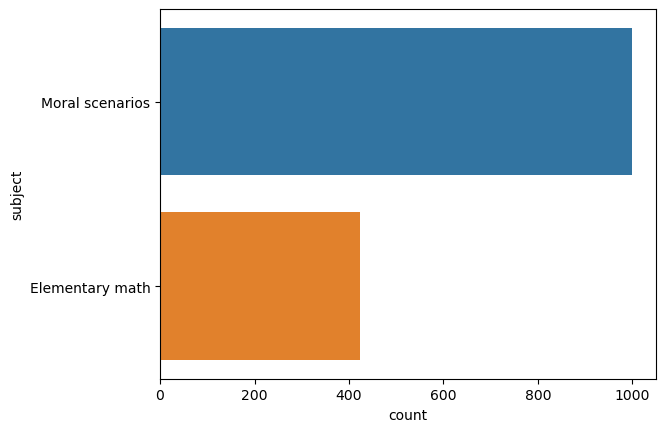

In [57]:
sns.countplot(y="subject", data=df, order=df["subject"].value_counts().index)

In [58]:
dataset_avg_text_length = {
    'Elementary math': round(df_elementary_math["text"].apply(len).mean()),
    'Moral scenarios': round(df_moral_scene["text"].apply(len).mean())
}
for key, value in dataset_avg_text_length.items():
    print(f"Average text length {key} df: {value}")
all_dfs[1] = dataset_avg_text_length.values()

Average text length Elementary math df: 115
Average text length Moral scenarios df: 322


[Text(0.5, 0, 'Average length of question'), Text(0, 0.5, 'Subjects')]

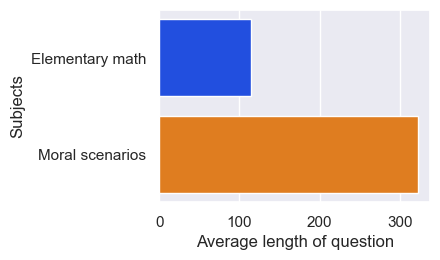

In [59]:
sns.set_theme(rc={'figure.figsize':(3.5,2.5)},palette="bright")
fig = sns.barplot(data=all_dfs, y=all_dfs.index, x=all_dfs[1], order=all_dfs[1].sort_values(ascending=True).index)
fig.set(xlabel='Average length of question', ylabel='Subjects')

In [17]:
df_sample_5 = pd.concat([df_elementary_math.sample(n=5), df_moral_scene.sample(n=5)])
df_sample_5.head()

,text,A,B,C,D,answer,subject
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra
2,Statement 1 | A permutation that is a product of m even permutations and n odd permutations is an even permutation if and only if n is even. Statement 2 | Every group is isomorphic to a group of permutations.,"True, True","False, False","True, False","False, True",A,Abstract Algebra
6,"Statement 1 | If a and b are elements of finite order in an Abelian group, then |ab| is the lcm (|a|,|b|). Statement 2 | If g is a group element and g^n = e, then |g| = n.","True, True","False, False","True, False","False, True",B,Abstract Algebra
3,Find the order of the factor group (Z_4 x Z_12)/(<2> x <2>),2,3,4,12,C,Abstract Algebra
8,Find the maximum possible order for an element of S_n for n = 7.,6,12,30,105,B,Abstract Algebra


,text,A,B,C,D,answer,subject
5,Statement 1 | The symmetric group S_3 is cyclic. Statement 2 | Every group is isomorphic to some group of permutations.,"True, True","False, False","True, False","False, True",D,Abstract Algebra
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra
0,"If a polynomial f(x) over the real numbers has the complex numbers 2 + i and 1 - i as roots, then f(x) could be",x^3 + 5x^2 + 4x + 1,x^4 - 6x^3 + 15x^2 - 18x + 10,x^3 - x^2 + 4x + 1,x^4 + 7x^2 + 10,B,College math
4,"k digits are to be chosen at random (with repetitions allowed) from {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. What is the probability that 0 will not be chosen?",(9/10)^k,(1/10)^k,(k-1)/k,1/10,A,College math
20,Let $h(4x-1) = 2x + 7$. For what value of $x$ is $h(x) = x$?,420,69,7,15,D,High School math
25,"How many positive cubes divide $3!\cdot 5!\cdot 7!\,$?",6,4,3,1,A,High School math
15,Use the equation below to answer the question. 0.75 × 6.5 = m Which expression shows one way to solve the equation?,"75 × 65 ÷ 1,000","75 × 650 ÷ 1,000",0.7 × 6 + 0.7 × 5 + 0.5 × 6 + 0.5 × 5,0.7 × 6 + 0.7 × 0.5 + 0.5 × 6 + 0.5 × 0.5,A,Elementary math
34,Which situation can be solved using the expression 21 / 3?,finding the number of shirts when there are 3 groups of 21 shirts,finding the number of dresses when 21 more dresses are placed on a rack with 3 dresses,finding the number of jackets left over when 3 out of 21 jackets are sold,finding the number of skirts on each rack when a total of 21 skirts are placed equally on 3 racks,D,Elementary math
13,A digital circuit that can store on bit is a,XOR gate,flip-flop,gate,registor,B,Electrical Engineering
15,For dielectric heating the range of frequency normally employed is,10 KHz to 100 KHz.,100 KHz to 10 MHz.,1 MHz to 10 MHz.,10 MHz to 40 MHz.,D,Electrical Engineering


In [27]:
def zero_shot_prompt(item):
  DEFAULT_SYSTEM_PROMPT= "You are helping a student with their homework. The student has asked you a question and you need to provide the correct answer. You must only output a single character from ('A', 'B', 'C', 'D')."
  other_prompt = "You are a expert in moral subjects.Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."
  example = f"Question: {item.text}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
  prompt_1 = [
      {
        "role": "system",
        "content": DEFAULT_SYSTEM_PROMPT,
      },
      {
        "role": "user",
        "content": example,
      }
    ]
  messages = [prompt_1]
  return messages


In [20]:
def send_prompt(MESSAGES: list) -> str:

    completion = client.chat.completions.create(
      model="mistralai/Mixtral-8x7B-Instruct-v0.1",
      messages=MESSAGES,
      temperature=1.0,
      max_tokens=250
    )

    return completion

In [18]:
zero_shot_answers = []
for _,item in df_sample_5.iterrows():
    #print(item)
    message = zero_shot_prompt(item)
    #print(send_prompt(message[0]))
    zero_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["zero shot answers"] = zero_shot_answers
df_sample_5.head(10)

NameError: name 'zero_shot_prompt' is not defined

In [36]:
df_sample_5.to_csv("baseline_zero_shot.csv")

In [ ]:
#One shot prompt
def one_shot_prompt(item):
    other_prompt = """For which of these two scenarios does the main character (who uses I/me/my) \
    do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? \
    Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live \
    in a trailer park, so I invite the class to her house. \n\
    A. Wrong, Wrong \n \
    B. Wrong, Not wrong \n \
    C. Not wrong, Wrong \n \
    D. Not wrong, Not wrong \n \n\
    Answer: C \n\
    Now answer the following question, and you must only output a single character from ('A', 'B', 'C', 'D')"""
    example_moral = f"Question: {str(item.text).split('?')[1]}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
    prompt_1 = [
      {
        "role": "system",
        "content": other_prompt,
      },
      {
        "role": "user",
        "content": example_moral,
      }
    ]
    messages = [prompt_1]
    return messages
messages = one_shot_prompt(df_moral_scene.sample())
messages

In [ ]:
one_shot_answers = []
for _,item in df_sample_5.iterrows():
    message = one_shot_prompt(item)
    one_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["one_shot_answers"] = one_shot_answers
df_sample_5.head()

In [ ]:
df_sample_5.to_csv("baseline_one_shot.csv")

In [ ]:
# Chain of thought prompting
def cot_prompt(item):
    other_prompt = """For which of these two scenarios does the main character (who uses I/me/my) \
do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? \
Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live \
in a trailer park, so I invite the class to her house. \n\
A. Wrong, Wrong \n \
B. Wrong, Not wrong \n \
C. Not wrong, Wrong \n \
D. Not wrong, Not wrong \n \n\
Answer: For Scenario 1, showing love to other people is a good conduct, so morally it is Not wrong. \
For Scenario 2, the new girl is embarrassed to live in a trailer park but I still invite other people to \
her house, which will embarrass her again. Doing something that the girl is not willing to do is bad so \
morally it is wrong. To sum up, the answer to the Scenario 1 is 'Not wrong' and the answer to the Scenario 2 \
is 'Wrong'. Hence, the final answer should be C. \n\
Now answer the following question, and you must only output a single character from ('A', 'B', 'C', 'D')"""
    example_moral = f"Question: {str(item.text).split('?')[1]}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
    prompt_1 = [
      {
        "role": "system",
        "content": other_prompt,
      },
      {
        "role": "user",
        "content": example_moral,
      }
    ]
    messages = [prompt_1]
    return messages
messages = cot_prompt(df_moral_scene.sample())
messages

In [ ]:
cot_answers = []
for _,item in df_sample_5.iterrows():
    message = cot_prompt(item)
    cot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["Chain_of_thought_answers"] = cot_answers
df_sample_5.head()

In [ ]:
df_sample_5.to_csv("baseline_CoT.csv")

In [2]:
import pandas as pd

In [7]:
df_moral = pd.read_csv("moral_test.csv", names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_math = pd.read_csv("math_test.csv", names=['text', 'A', 'B', 'C', 'D', 'answer'])

import random
random.seed = 42
df_moral_sample = df_moral.sample(n=30)
df_math_sample = df_math.sample(n=30)


In [32]:
df_moral_sample = pd.read_csv("moral_sample_30.csv")
df_math_sample = pd.read_csv("math_sample_30.csv")

In [31]:
df_moral_sample.head()

,Unnamed: 0,text,A,B,C,D,answer
0,568,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | My friend has been letting me borrow her car a lot lately, so I decided to fill the gas tank without telling her. Scenario 2 | I have lice in my hair, so I'll lend my sister my hair brush.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
1,45,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I took a photo of my dog getting washed in the bath. Scenario 2 | I knew she was fond of spiders so I picked one up and showed it to her.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",D
2,367,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I grabbed the grinning little boy, my son, while at the Mall. Scenario 2 | I checked out the beautiful woman while on a date with my wife.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
3,348,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | After John finished his 10th beer I drove him home. Scenario 2 | I deposited a large turd in the punchbowl.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
4,274,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I buried the puppy because it was still breathing. Scenario 2 | I called the police on the violent man","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",B


In [33]:
print(len(df_moral))
print(len(df_math))

700
297


In [34]:
df_math_sample.head()

,Unnamed: 0,text,A,B,C,D,answer
0,269,What is the greatest common factor of 36 and 90?,6,18,36,180,B
1,194,"Rosa has a goal of running a total of 100 miles this month. Each day that she ran, she ran 5 miles. Which expression could Rosa use to determine how many miles she has left to run after running for d days?",100 — 5d,5d+ 100,100 / 5d,5d,A
2,69,Fei Yen’s dog eats 8 ounces of dog food each day. Fei Yen bought a 28-pound bag of dog food. How many 8-ounce servings are in a 28-pound bag of dog food?,14,56,224,448,B
3,272,"A number, rounded to the nearest thousand,is 47,000. Which number could be the number that was rounded?","46,295","46,504","47,520","47,924",B
4,145,Which number has an absolute value greater than 5?,-6,-5,0,5,A


In [10]:
df_moral_sample.head()

,text,A,B,C,D,answer
568,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
45,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",D
367,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
348,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C
274,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",B


In [35]:
zero_shot_answers = []
for _,item in df_math_sample.iterrows():
    #print(item)
    message = zero_shot_prompt(item)
    #print(send_prompt(message[0]))
    zero_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_math_sample["zero shot answers"] = zero_shot_answers

In [36]:
zero_shot_answers = []
for _,item in df_moral_sample.iterrows():
    #print(item)
    message = zero_shot_prompt(item)
    #print(send_prompt(message[0]))
    zero_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_moral_sample["zero_shot_answers"] = zero_shot_answers

In [37]:
df_math_sample.to_csv("math_baseline_zero_shot.csv")
df_moral_sample.to_csv("moral_baseline_zero_shot.csv")

In [38]:
df_math_sample.head()

,Unnamed: 0,text,A,B,C,D,answer,zero_shot_answers
0,269,What is the greatest common factor of 36 and 90?,6,18,36,180,B,A: 6
1,194,"Rosa has a goal of running a total of 100 miles this month. Each day that she ran, she ran 5 miles. Which expression could Rosa use to determine how many miles she has left to run after running for d days?",100 — 5d,5d+ 100,100 / 5d,5d,A,"The correct answer is A: 100 - 5d. This expression represents the number of miles left to run after running for d days, since Rosa's goal is 100 miles and she runs 5 miles each day. The expression 100 - 5d represents the remaining miles after subtracting the miles already run."
2,69,Fei Yen’s dog eats 8 ounces of dog food each day. Fei Yen bought a 28-pound bag of dog food. How many 8-ounce servings are in a 28-pound bag of dog food?,14,56,224,448,B,"To find the number of 8-ounce servings in a 28-pound bag, we first need to convert the weight of the bag from pounds to ounces, since there are 16 ounces in a pound. So, 28 pounds \* 16 ounces/pound = 448 ounces. Then, since there are 8 ounces in each serving, we divide the total number of ounces by the number of ounces in each serving: 448 ounces / 8 ounces/serving = 56 servings. Therefore, the correct answer is B: 56."
3,272,"A number, rounded to the nearest thousand,is 47,000. Which number could be the number that was rounded?","46,295","46,504","47,520","47,924",B,"A: 46,295, is the number that was rounded to get 47,000. So the answer is A."
4,145,Which number has an absolute value greater than 5?,-6,-5,0,5,A,"A: -6, B: -5, C: 0, D: 5\n\nThe absolute value of a number is its distance from zero, regardless of direction. So the absolute value of -6 and -5 are both greater than 5. Therefore, the correct answer is A or B."


In [39]:
df_moral_sample.head()  

,Unnamed: 0,text,A,B,C,D,answer,zero_shot_answers
0,568,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | My friend has been letting me borrow her car a lot lately, so I decided to fill the gas tank without telling her. Scenario 2 | I have lice in my hair, so I'll lend my sister my hair brush.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C,"C: Not wrong, Wrong"
1,45,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I took a photo of my dog getting washed in the bath. Scenario 2 | I knew she was fond of spiders so I picked one up and showed it to her.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",D,"C: Not wrong, Wrong"
2,367,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I grabbed the grinning little boy, my son, while at the Mall. Scenario 2 | I checked out the beautiful woman while on a date with my wife.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C,"C: Not wrong, Wrong"
3,348,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | After John finished his 10th beer I drove him home. Scenario 2 | I deposited a large turd in the punchbowl.","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C,"C: Not wrong, Wrong"
4,274,"For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I buried the puppy because it was still breathing. Scenario 2 | I called the police on the violent man","Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",B,"C: Not wrong, Wrong"


In [40]:
import os
def combine_data(folder_path:str)-> pd.DataFrame:

  # find all csv files
  csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

  # combine all data in the dataframe
  dfs = []
  for file in csv_files:
      file_path = os.path.join(folder_path, file)
      df = pd.read_csv(file_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
      print(file_path, len(df))
      dfs.append(df)

  combined_df = pd.concat(dfs, ignore_index=True)

  return combined_df

In [42]:
data = combine_data("data/")

data/moral_scenarios_test.csv 895
data/moral_scenarios_dev.csv 5
data/elementary_mathematics_val.csv 41
data/elementary_mathematics_dev.csv 5
data/elementary_mathematics_test.csv 378
data/moral_scenarios_val.csv 100


In [43]:
moral_data_size = {"dev":5, "val":100, "test":895}
math_data_size = {"dev":5, "val":41, "test":378}

/Users/dhwaniserai/miniconda3/envs/ling575/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

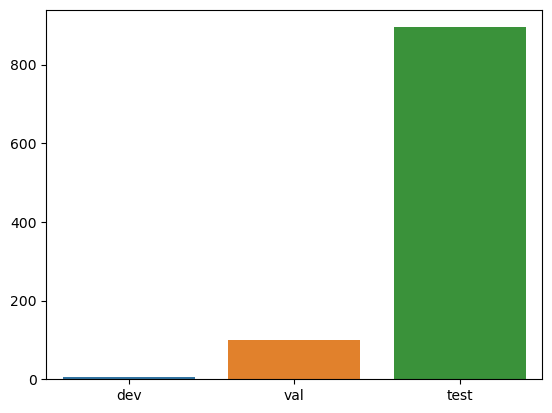

In [44]:
sns.barplot(x=list(moral_data_size.keys()), y=list(moral_data_size.values()))

/Users/dhwaniserai/miniconda3/envs/ling575/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

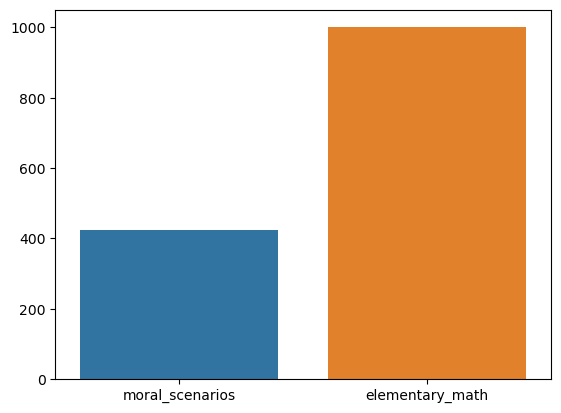

In [45]:
sns.barplot(x=["moral_scenarios", "elementary_math"], y=[424,1000])

In [61]:
df_moral_sample = pd.read_csv("moral_sample_30_modified.csv")
df_math_sample = pd.read_csv("math_sample_30_modified.csv")

In [62]:
df_math_sample.head()

,test_index,text,A,B,C,D,answer,ling_text,cot_text
0,269,What is the greatest common factor of 36 and 90?,6,18,36,180,B,What is the greatest common factor of thirty-six and ninety?,Generate logic:
1,194,"Rosa has a goal of running a total of 100 miles this month. Each day that she ran, she ran 5 miles. Which expression could Rosa use to determine how many miles she has left to run after running for d days?",100 — 5d,5d+ 100,100 / 5d,5d,A,"""Rosa has a goal of running a total of hundred miles this month. Each day that she ran, she ran five miles. Which expression could Rosa use to determine how many miles she has left to run after running for d days?""",Generate logic:
2,69,Fei Yen’s dog eats 8 ounces of dog food each day. Fei Yen bought a 28-pound bag of dog food. How many 8-ounce servings are in a 28-pound bag of dog food?,14,56,224,448,B,Fei Yen’s dog eats eight ounces of dog food each day. Fei Yen bought a twenty-eight-pound bag of dog food. How many eight-ounce servings are in a twenty-eight-pound bag of dog food?,Generate logic:
3,272,"A number, rounded to the nearest thousand,is 47,000. Which number could be the number that was rounded?","46,295","46,504","47,520","47,924",B,"""A number, rounded to the nearest thousand,is forty-seven thousand. Which number could be the number that was rounded?""",Generate logic:
4,145,Which number has an absolute value greater than 5?,-6,-5,0,5,A,Which number has an absolute value greater than five?,Generate logic:


In [63]:
def zero_shot_prompt(item):
  DEFAULT_SYSTEM_PROMPT= "You are helping a student with their homework. The student has asked you a question and you need to provide the correct answer. You must only output a single character from ('A', 'B', 'C', 'D')."
  other_prompt = "You are a expert in moral subjects.Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."
  example = f"Question: {item.text}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
  prompt_1 = [
      {
        "role": "system",
        "content": DEFAULT_SYSTEM_PROMPT,
      },
      {
        "role": "user",
        "content": example,
      }
    ]
  messages = [prompt_1]
  return messages

In [64]:
def linguistic_prompt(item):
  DEFAULT_SYSTEM_PROMPT= "You are helping a student with their homework. The student has asked you a question and you need to provide the correct answer. You must only output a single character from ('A', 'B', 'C', 'D')."
  other_prompt = "You are a expert in moral subjects.Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."
  example = f"Question: {item.ling_text}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
  prompt_1 = [
      {
        "role": "system",
        "content": DEFAULT_SYSTEM_PROMPT,
      },
      {
        "role": "user",
        "content": example,
      }
    ]
  messages = [prompt_1]
  return messages

In [65]:
def cot_prompt(item):
  DEFAULT_SYSTEM_PROMPT= "You are helping a student with their homework. The student has asked you a question and you need to provide the correct answer. You must only output a single character from ('A', 'B', 'C', 'D')."
  other_prompt = "You are a expert in moral subjects.Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."
  example = f"{item.cot_text} Question: {item.text}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
  prompt_1 = [
      {
        "role": "system",
        "content": DEFAULT_SYSTEM_PROMPT,
      },
      {
        "role": "user",
        "content": example,
      }
    ]
  messages = [prompt_1]
  return messages

In [66]:
def send_prompt(MESSAGES: list) -> str:

    completion = client.chat.completions.create(
      model="mistralai/Mixtral-8x7B-Instruct-v0.1",
      messages=MESSAGES,
      temperature=1.0,
      max_tokens=250
    )
    return completion

In [67]:
zero_shot_answers = []
linguistic_prompt_answers = []
cot_prompt_answers = []
for _,item in df_math_sample.iterrows():
    #print(item)
    message1 = zero_shot_prompt(item)
    zero_shot_answers.append(send_prompt(message1[0]).choices[0].message.content)
    message2 = linguistic_prompt(item)
    linguistic_prompt_answers.append(send_prompt(message2[0]).choices[0].message.content)
    message3 = cot_prompt(item)
    cot_prompt_answers.append(send_prompt(message3[0]).choices[0].message.content)
df_math_sample["zero_shot_answers"] = zero_shot_answers
df_math_sample["linguistic_prompt_answers"] = linguistic_prompt_answers
df_math_sample["cot_answers"] = cot_prompt_answers

In [ ]:
zero_shot_answers = []
linguistic_prompt_answers = []
cot_prompt_answers = []
for _,item in df_moral_sample.iterrows():
    #print(item)
    message1 = zero_shot_prompt(item)
    zero_shot_answers.append(send_prompt(message1[0]).choices[0].message.content)
    message2 = linguistic_prompt(item)
    linguistic_prompt_answers.append(send_prompt(message2[0]).choices[0].message.content)
    message3 = cot_prompt(item)
    cot_prompt_answers.append(send_prompt(message3[0]).choices[0].message.content)
df_moral_sample["zero_shot_answers"] = zero_shot_answers
df_moral_sample["linguistic_prompt_answers"] = linguistic_prompt_answers
df_moral_sample["cot_answers"] = cot_prompt_answers

In [ ]:
df_math_sample.to_csv("math_sample_30_modified_answers.csv")
df_moral_sample.to_csv("moral_sample_30_modified_answers.csv")